In [1]:
!pip install scipy==0.18.1

     |████████████████████████████████| 42.5MB 54kB/s 
ERROR: yellowbrick 0.9.1 has requirement scipy>=1.0.0, but you'll have scipy 0.18.1 which is incompatible.
ERROR: umap-learn 0.3.10 has requirement scipy>=0.19, but you'll have scipy 0.18.1 which is incompatible.
ERROR: plotnine 0.5.1 has requirement scipy>=1.0.0, but you'll have scipy 0.18.1 which is incompatible.
ERROR: mir-eval 0.5 has requirement scipy>=1.0.0, but you'll have scipy 0.18.1 which is incompatible.
ERROR: librosa 0.6.3 has requirement scipy>=1.0.0, but you'll have scipy 0.18.1 which is incompatible.
ERROR: cvxpy 1.0.25 has requirement scipy>=1.1.0, but you'll have scipy 0.18.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.3
    Uninstalling scipy-1.3.3:
      Successfully uninstalled scipy-1.3.3


In [2]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from skimage.transform import resize
import cv2, skimage
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import seaborn as sns
import math

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add, GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import glob


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data
!cp '/content/drive/My Drive/RWTHFingerSpelling.zip' .
!unzip -q RWTHFingerSpelling.zip
!mv train test data/

In [5]:
!git clone https://github.com/lmb-freiburg/hand3d.git

Cloning into 'hand3d'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [6]:
!ls hand3d
!wget --no-check-certificate https://lmb.informatik.uni-freiburg.de/projects/hand3d/ColorHandPose3D_data_v3.zip

create_binary_db.py   eval3d.py     README.md		    training_lifting.py
data		      eval_full.py  run.py		    training_posenet.py
eval2d_gt_cropped.py  LICENSE	    teaser.png		    utils
eval2d.py	      nets	    training_handsegnet.py
--2019-12-18 17:05:03--  https://lmb.informatik.uni-freiburg.de/projects/hand3d/ColorHandPose3D_data_v3.zip
Resolving lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)... 132.230.167.23
Connecting to lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 661880210 (631M) [application/zip]
Saving to: ‘ColorHandPose3D_data_v3.zip’

ColorHandPose3D_dat 100%[===================>] 631.22M  5.06MB/s    in 1m 45s  

2019-12-18 17:06:49 (5.99 MB/s) - ‘ColorHandPose3D_data_v3.zip’ saved [661880210/661880210]



In [0]:
!unzip -q ColorHandPose3D_data_v3.zip
!cp -r data results weights hand3d/

In [8]:
os.chdir('hand3d')
print(os.getcwd())

/content/hand3d


In [0]:
from __future__ import print_function, unicode_literals

import tensorflow as tf
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from nets.ColorHandPose3DNetwork import ColorHandPose3DNetwork
from utils.general import detect_keypoints, trafo_coords, plot_hand, plot_hand_3d

In [10]:
  #
  #  ColorHandPose3DNetwork - Network for estimating 3D Hand Pose from a single RGB Image
  #  Copyright (C) 2017  Christian Zimmermann
  #  
  #  This program is free software: you can redistribute it and/or modify
  #  it under the terms of the GNU General Public License as published by
  #  the Free Software Foundation, either version 2 of the License, or
  #  (at your option) any later version.
  #  
  #  This program is distributed in the hope that it will be useful,
  #  but WITHOUT ANY WARRANTY; without even the implied warranty of
  #  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
  #  GNU General Public License for more details.
  #  
  #  You should have received a copy of the GNU General Public License
  #  along with this program.  If not, see <http://www.gnu.org/licenses/>.
  #
  

  #if __name__ == '__main__':
      # images to be shown
  # image_list = list()
  # image_list.append('/content/data/train/14/10_14_1_cam1_00000030.jpg')
  # image_list.append('/content/data/train/14/10_14_1_cam1_00000031.jpg')

  # # image_list.append('/content/data/train/19/11_19_1_cam1_00000034.jpg')
  # # image_list.append('/content/data/train/11/10_11_1_cam1_00000030.jpg')
  # # image_list.append('/content/data/train/11/11_11_1_cam1_00000034.jpg')

  
      # network input
  tf.reset_default_graph()
  image_tf = tf.placeholder(tf.float32, shape=(1, 240, 320, 3))
  
  hand_side_tf = tf.constant([[0.0, 1.0]])  # left hand (true for all samples provided)
  evaluation = tf.placeholder_with_default(True, shape=())

      # build network
  net = ColorHandPose3DNetwork()
  hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,\
  keypoints_scoremap_tf, keypoint_coord3d_tf = net.inference(image_tf, hand_side_tf, evaluation)

      # Start TF
  gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
  sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

      # initialize network
  net.init(sess)

      # Feed image list through network





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded 32 variables from ./weights/handsegnet-rhd.pickle
Loaded 102 variables from ./weights/posenet3d-rhd-stb-slr-finetuned.pickle


In [13]:
  labels = [i for i in range(1, 36) if i not in [10, 26, 27, 28, 29]]
  session = 2
  folder = "data/test/"
  keyFeatures = []
  keyLabels = []
  for label in labels:
      for person in range(1, 21):
        img_pattern = "{}{}/{}_{}_{}_cam1_*.jpg".format(folder, label, person, label, session)
        print(img_pattern)
        for img_path in glob.glob(img_pattern):
            image_raw = scipy.misc.imread(img_path)
            image_raw = scipy.misc.imresize(image_raw, (240, 320))
            image_v = np.expand_dims((image_raw.astype('float') / 255.0) - 0.5, 0)
            hand_scoremap_v, image_crop_v, scale_v, center_v,\
            keypoints_scoremap_v, keypoint_coord3d_v = sess.run([hand_scoremap_tf, image_crop_tf, scale_tf, center_tf,
                                                                keypoints_scoremap_tf, keypoint_coord3d_tf],
                                                                feed_dict={image_tf: image_v})

            hand_scoremap_v = np.squeeze(hand_scoremap_v)
            image_crop_v = np.squeeze(image_crop_v)
            keypoints_scoremap_v = np.squeeze(keypoints_scoremap_v)
            keypoint_coord3d_v = np.squeeze(keypoint_coord3d_v)

            # post processing
            image_crop_v = ((image_crop_v + 0.5) * 255).astype('uint8')
            coord_hw_crop = detect_keypoints(np.squeeze(keypoints_scoremap_v))
            # coord_hw = trafo_coords(coord_hw_crop, center_v, scale_v, 256)
            keyFeatures.append(coord_hw_crop)
            keyLabels.append((label, person, session, "cam1"))

            # visualize
            # plt.subplots(squeeze=False)
            # fig = plt.figure(1)
            # ax1 = fig.add_subplot(221)
            # ax2 = fig.add_subplot(222)
            # ax3 = fig.add_subplot(223)
            # ax4 = fig.add_subplot(224, projection='3d')
            # ax1.imshow(image_raw)
            # plot_hand(coord_hw, ax1)
            # ax2.imshow(image_crop_v)
            # plot_hand(coord_hw_crop, ax2)
            # ax3.imshow(np.argmax(hand_scoremap_v, 2))
            # plot_hand_3d(keypoint_coord3d_v, ax4)
            # ax4.view_init(azim=-90.0, elev=-90.0)  # aligns the 3d coord with the camera view
            # ax4.set_xlim([-3, 3])
            # ax4.set_ylim([-3, 1])
            # ax4.set_zlim([-3, 3])
            # plt.show()
            break
  np.save('/content/drive/My Drive/datasetRWTH/testkeyFeatures',np.array(keyFeatures))
  np.save('/content/drive/My Drive/datasetRWTH/testkeyLabels',np.array(keyLabels))

data/test/1/1_1_2_cam1_*.jpg


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


data/test/1/2_1_2_cam1_*.jpg
data/test/1/3_1_2_cam1_*.jpg
data/test/1/4_1_2_cam1_*.jpg
data/test/1/5_1_2_cam1_*.jpg
data/test/1/6_1_2_cam1_*.jpg
data/test/1/7_1_2_cam1_*.jpg
data/test/1/8_1_2_cam1_*.jpg
data/test/1/9_1_2_cam1_*.jpg
data/test/1/10_1_2_cam1_*.jpg
data/test/1/11_1_2_cam1_*.jpg
data/test/1/12_1_2_cam1_*.jpg
data/test/1/13_1_2_cam1_*.jpg
data/test/1/14_1_2_cam1_*.jpg
data/test/1/15_1_2_cam1_*.jpg
data/test/1/16_1_2_cam1_*.jpg
data/test/1/17_1_2_cam1_*.jpg
data/test/1/18_1_2_cam1_*.jpg
data/test/1/19_1_2_cam1_*.jpg
data/test/1/20_1_2_cam1_*.jpg
data/test/2/1_2_2_cam1_*.jpg
data/test/2/2_2_2_cam1_*.jpg
data/test/2/3_2_2_cam1_*.jpg
data/test/2/4_2_2_cam1_*.jpg
data/test/2/5_2_2_cam1_*.jpg
data/test/2/6_2_2_cam1_*.jpg
data/test/2/7_2_2_cam1_*.jpg
data/test/2/8_2_2_cam1_*.jpg
data/test/2/9_2_2_cam1_*.jpg
data/test/2/10_2_2_cam1_*.jpg
data/test/2/11_2_2_cam1_*.jpg
data/test/2/12_2_2_cam1_*.jpg
data/test/2/13_2_2_cam1_*.jpg
data/test/2/14_2_2_cam1_*.jpg
data/test/2/15_2_2_cam1_*.j

In [12]:
glob.glob("data/test/1/1_1_1_cam1_*.jpg")

[]

In [90]:
keyFeaturesArray = np.load("/content/drive/My Drive/datasetRWTH/keyFeatures.npy")
keyLabelsArray = np.load("/content/drive/My Drive/datasetRWTH/keyLabels.npy")
keyLabelsDf = pd.DataFrame(keyLabelsArray, columns=["label", "person", "session", "camera"])
keyLabelsDf

,label,person,session,camera
0,1,1,1,cam1
1,1,2,1,cam1
2,1,3,1,cam1
3,1,4,1,cam1
4,1,5,1,cam1
...,...,...,...,...
595,35,16,1,cam1
596,35,17,1,cam1
597,35,18,1,cam1
598,35,19,1,cam1


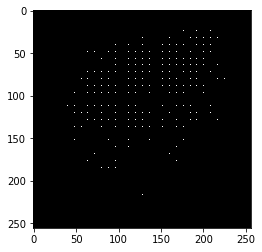

In [72]:
keyPoints = np.zeros((256, 256))
for keyPoint in keyFeaturesArray:
  keyPoint = keyPoint.astype('int')
  keyPoints[keyPoint[:,0], keyPoint[:,1]]=1
plt.imshow(keyPoints, 'gray')

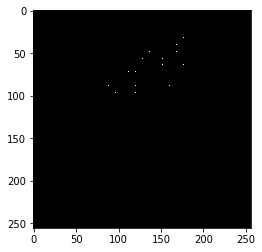

In [82]:
keyPoints = np.zeros((256, 256))
for keyPoint in keyFeatures:
  keyPoint = keyPoint.astype('int')
  keyPoints[keyPoint[:,0], keyPoint[:,1]]=1
  break
plt.imshow(keyPoints, 'gray')